# Tutorial: Morpho algorithm benchmark

In [1]:
# install dependecies
!pip install nevergrad

## load modules

In [2]:
import time
import copy

import nevergrad as ng
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

## setup model, problem and optimizer

First we repeat the setup of the morpho problem

In [3]:
i = complex(0,1)

### RCWA functions
def cascade(T,U):
    n=int(T.shape[1]/2)
    J=np.linalg.inv(np.eye(n)-np.matmul(U[0:n,0:n],T[n:2*n,n:2*n]))
    K=np.linalg.inv(np.eye(n)-np.matmul(T[n:2*n,n:2*n],U[0:n,0:n]))
    S=np.block([[T[0:n,0:n]+np.matmul(np.matmul(np.matmul(T[0:n,n:2*n],J),U[0:n,0:n]),T[n:2*n,0:n]),np.matmul(np.matmul(T[0:n,n:2*n],J),U[0:n,n:2*n])],[np.matmul(np.matmul(U[n:2*n,0:n],K),T[n:2*n,0:n]),U[n:2*n,n:2*n]+np.matmul(np.matmul(np.matmul(U[n:2*n,0:n],K),T[n:2*n,n:2*n]),U[0:n,n:2*n])]])
    return S

def c_bas(A,V,h):
    n=int(A.shape[1]/2)
    D=np.diag(np.exp(1j*V*h))
    S=np.block([[A[0:n,0:n],np.matmul(A[0:n,n:2*n],D)],[np.matmul(D,A[n:2*n,0:n]),np.matmul(np.matmul(D,A[n:2*n,n:2*n]),D)]])
    return S

def marche(a,b,p,n,x):
    from scipy.linalg import toeplitz
    l=np.zeros(n,dtype=np.complex128)
    m=np.zeros(n,dtype=np.complex128)
    tmp=1/(2*np.pi*np.arange(1,n))*(np.exp(-2*1j*np.pi*p*np.arange(1,n))-1)*np.exp(-2*1j*np.pi*np.arange(1,n)*x)
    l[1:n]=1j*(a-b)*tmp
    l[0]=p*a+(1-p)*b
    m[0]=l[0]
    m[1:n]=1j*(b-a)*np.conj(tmp)
    T=toeplitz(l,m)
    return T

def creneau(k0,a0,pol,e1,e2,a,n,x0):
    nmod=int(n/2)
    alpha=np.diag(a0+2*np.pi*np.arange(-nmod,nmod+1))
    if (pol==0):
        M=alpha*alpha-k0*k0*marche(e1,e2,a,n,x0)
        L,E=np.linalg.eig(M)
        L=np.sqrt(-L+0j)
        L=(1-2*(np.imag(L)<-1e-15))*L
        P=np.block([[E],[np.matmul(E,np.diag(L))]])
    else:
        U=marche(1/e1,1/e2,a,n,x0)
        T=np.linalg.inv(U)
        M=np.matmul(np.matmul(np.matmul(T,alpha),np.linalg.inv(marche(e1,e2,a,n,x0))),alpha)-k0*k0*T
        L,E=np.linalg.eig(M)
        L=np.sqrt(-L+0j)
        L=(1-2*(np.imag(L)<-1e-15))*L
        P=np.block([[E],[np.matmul(np.matmul(U,E),np.diag(L))]])
    return P,L

def homogene(k0,a0,pol,epsilon,n):
    nmod=int(n/2)
    valp=np.sqrt(epsilon*k0*k0-(a0+2*np.pi*np.arange(-nmod,nmod+1))**2+0j)
    valp=valp*(1-2*(valp<0))*(pol/epsilon+(1-pol))
    P=np.block([[np.eye(n)],[np.diag(valp)]])
    return P,valp

def interface(P,Q):
    n=int(P.shape[1])
    S=np.matmul(np.linalg.inv(np.block([[P[0:n,0:n],-Q[0:n,0:n]],[P[n:2*n,0:n],Q[n:2*n,0:n]]])),np.block([[-P[0:n,0:n],Q[0:n,0:n]],[P[n:2*n,0:n],Q[n:2*n,0:n]]]))
    return S

### Cost function
def cost_morpho(x):
    lam_blue = 449.5897
    pol = 1
    d = 600.521475
    nmod = 25
    e2 = 2.4336
    n = 2 * nmod + 1
    n_motifs = int(x.size / 3)
    x = x / d
    h = x[n_motifs : 2*n_motifs]
    x0 = x[2 * n_motifs : 3 * n_motifs]
    a = x[0:n_motifs]
    spacers = np.zeros(a.size)

    #Maximization of the blue specular reflection
    l = lam_blue / d
    k0 = 2 * np.pi / l
    P, V = homogene(k0, 0, pol, 1, n)
    S = np.block([[np.zeros([n, n]), np.eye(n, dtype=np.complex128)], [np.eye(n), np.zeros([n, n])]])
    for j in range(0, n_motifs):
        Pc, Vc = creneau(k0, 0, pol, e2, 1, a[j], n, x0[j])
        S = cascade(S, interface(P, Pc))
        S = c_bas(S, Vc, h[j])
        S = cascade(S, interface(Pc, P))
        S = c_bas(S, V, spacers[j])
    Pc, Vc = homogene(k0, 0, pol, e2, n)
    S = cascade(S, interface(P, Pc))
    R = np.zeros(3, dtype=float)
    for j in range(-1, 2):
        R[j] = abs(S[j + nmod, nmod]) ** 2 * np.real(V[j + nmod]) / k0
    cost = 1 - (R[-1] + R[1]) / 2 + R[0] / 2

    return(cost)

## Setup the optimizer

In [4]:
nb_layers = 5
min_w = 0
max_w = 600
min_thick = 0
max_thick = 200
min_p = 0
max_p = 600

parametrization = ng.p.Array(
    init=[min_w]*nb_layers + [min_thick]*nb_layers + [min_p]*nb_layers,
    lower=[min_w]*nb_layers + [min_thick]*nb_layers + [min_p]*nb_layers,
    upper=[max_w]*nb_layers + [max_thick]*nb_layers + [max_p]*nb_layers,
)

## Running multiple optimizations

run the optimization with several optimizers in an attempt to find the best suited algorithm for our problem.

In [6]:
budget = 100 * nb_layers * 3  # stop criterion: allowed number of evaluations.
                              # Less budget than in other experiments because
                              # of the computational cost of the objective function.
N_repet_each = 5 # how often to repeat the run with each optimizer

# iterate through list of algorithms to use
list_optims = ["BFGS", "DE", "QNDE", "CMA", "NGOpt"]

# init results container dict
hist_cost = {}
hist_best_f = {}
for optim_name in list_optims:
    hist_cost[optim_name] = []
    hist_best_f[optim_name] = []

# perform optimizations
for optim_name in list_optims:
    print('running optimizer: "{}"'.format(optim_name))

    # run the optimizer multiple times
    t0 = time.time()
    for k in tqdm(range(N_repet_each)):

        # initialize the parametrization and the optimizer
        #instru = copy.deepcopy(parametrization)  # clean copy of instrumentation
        instru = ng.p.Array(
          init=[min_w]*nb_layers + [min_thick]*nb_layers + [min_p]*nb_layers,
          lower=[min_w]*nb_layers + [min_thick]*nb_layers + [min_p]*nb_layers,
          upper=[max_w]*nb_layers + [max_thick]*nb_layers + [max_p]*nb_layers,
          )
        optimizer = ng.optimizers.registry[optim_name](instru, budget)

        # init tracking values
        best_f = float("inf") # container for best solution
        yval = []             # container for convergence curve

        # the actual optimization loop
        for k in range(budget):
            x = optimizer.ask()   # get suggestion for new test structure

            y = cost_morpho(x.value) # eval. the optimizer's suggestion
            optimizer.tell(x, y)  # tell the cost to the optimizer

            if y < best_f:
                best_f = y
            yval.append(best_f)

        # add results of run to history
        hist_cost[optim_name].append(yval)
        hist_best_f[optim_name].append(best_f)


running optimizer: "BFGS"


100%|██████████| 5/5 [13:48<00:00, 165.76s/it]


running optimizer: "DE"


100%|██████████| 5/5 [12:55<00:00, 155.17s/it]


running optimizer: "QNDE"


100%|██████████| 5/5 [12:50<00:00, 154.00s/it]


running optimizer: "CMA"


100%|██████████| 5/5 [13:04<00:00, 156.97s/it]


running optimizer: "NGOpt"


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:2982: RuntimeWarning: overflow encountered in scalar multiply
  tmp1 = (xb - xa) * (fb - fc)
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:2983: RuntimeWarning: overflow encountered in scalar multiply
  tmp2 = (xb - xc) * (fb - fa)
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:2984: RuntimeWarning: invalid value encountered in scalar subtract
  val = tmp2 - tmp1
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:2982: RuntimeWarning: overflow encountered in scalar multiply
  tmp1 = (xb - xa) * (fb - fc)
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:2983: RuntimeWarning: overflow encountered in scalar multiply
  tmp2 = (xb - xc) * (fb - fa)
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:2984: RuntimeWarning: invalid value encountered in scal

## Plot the convergence

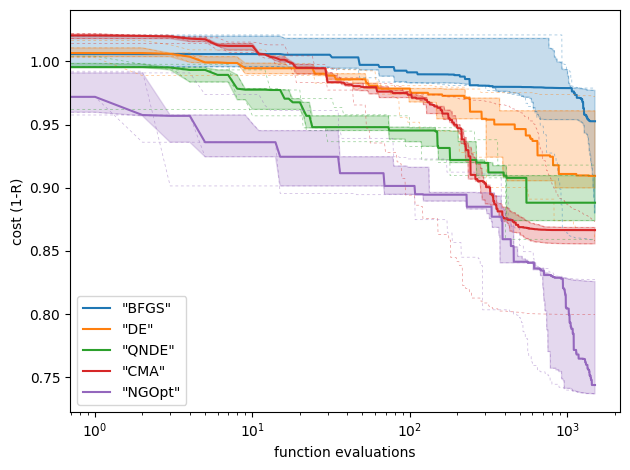

In [7]:
colors = [f'C{i}' for i in range(10)]

for i_opt, k in enumerate(hist_cost):
    for i, convergence in enumerate(hist_cost[k]):
        plt.plot(convergence, color=colors[i_opt], lw=0.5, alpha=0.5, dashes=[4,4])

    plt.plot(np.median(hist_cost[k], axis=0), color=colors[i_opt], label=f'"{k}"')
    plt.fill_between(np.arange(len(hist_cost[k][0])),
                     np.quantile(hist_cost[k], 0.25, axis=0),
                     np.quantile(hist_cost[k], 0.75, axis=0),
                     color=colors[i_opt],
                     alpha=0.25)

plt.xscale('log')

plt.xlabel('function evaluations')
plt.ylabel('cost (1-R)')
plt.legend()

plt.tight_layout()
plt.show()

## plot the consistency test

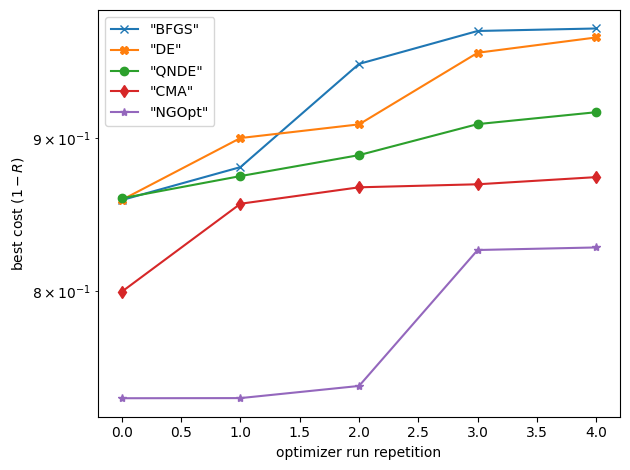

In [8]:
colors = [f'C{i}' for i in range(10)]
markers = ['x', 'X', 'o', 'd', '*', 'D']

for i_opt, k in enumerate(hist_best_f):
    plt.plot(np.sort(hist_best_f[k]), color=colors[i_opt], marker=markers[i_opt], label=f'"{k}"')

plt.xlabel('optimizer run repetition')
plt.ylabel('best cost ($1-R$)')
plt.yscale('log')
plt.legend()
plt.tight_layout()
plt.show()